<img src='https://d12dkjq56sjcos.cloudfront.net/pub/media/wysiwyg/route-images/View-Of-San-Francisco-City-Tour-Slider-Big-Bus-Tours-01.17.jpg'>

# Capstone Project - The Battle of the Neighborhoods
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
* [Introduction: Business Problem](#introduction)
* [Data](#data)
* [Methodology](#methodology)
* [Data Preparation](#datapreparation)
* [Analysis](#analysis)
* [Results and Discussion](#results)
* [Conclusion](#conclusion)

## Introduction: Business Problem <a name="introduction"></a>

In this project, we will try to find an optimal neighborhood for opening a restaurant. Specifically, this report will be targeted to stakeholders interested in opening a restaurant in **San Francisco**, California.

There are lots of restaurants in San Francisco. We will try to detect locations that are already crowded with restaurants as an indicator of high demand. At the same time, we are also particularly interested in opening a cuisine not frequently found in the city. 

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area, such as its average rent prices, will also be taken into account so the best possible final location can be chosen by stakeholders.

## Data <a name="data"></a>

The following data sources will be used in the project:

1. **Relational Database: Average Rent in San Francisco, CA By Neighborhood.**
    
    Source:  https://www.rentcafe.com/average-rent-market-trends/us/ca/san-francisco/
    
    This data will be used throughout the project for different purposes. For example, finding the coordinates of each neighborhood, mapping those coordinates, and finding the best possible neighborhoods based on their average rent prices.
    
    
2. **Foursquare API.**

    Documentation: https://developer.foursquare.com/docs
    
    With this API, we'll get location data of the different neighborhoods in San Francisco. 

## Methodology <a name="methodology"></a>

In this project, we will direct our efforts on detecting neighborhoods of San Francisco that have high restaurant density. We will also find what type of cuisine is not frequently found in those neighborhoods.

In the first step, we collect the required data, prepare it, and visualize it in a map of San Francisco using the Folium library.

Then, with the Foursquare API, we gather information about the different venues around each neighborhood. Focusing on finding venues that match the definition of a restaurant.

In the third step, we use a DBSCAN algorithm from the Sklearn library to cluster the data.

Finally, we analyze the clusters of high restaurant density and make final observations to find an optimal neighborhood for opening a restaurant in San Francisco.

## Data Preparation <a name="datapreparation"></a>

First, let's import all the libraries needed:

In [191]:
import numpy as np

import pandas as pd 
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json 

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim 

from bs4 import BeautifulSoup
import requests 
from pandas.io.json import json_normalize 


import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt

import seaborn as sns

!conda install -c conda-forge folium=0.5.0 --yes 
import folium 

from sklearn.cluster import DBSCAN
from geopy.distance import great_circle

!conda install -c conda-forge shapely --yes
from shapely.geometry import MultiPoint

print('Libraries imported.')

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Solving environment: done

# All requested packages already installed.

Libraries imported.


Now, we'll scrape the website where the relational database for neighborhoods and their average rent can be found:

In [192]:
website_url = requests.get('https://www.rentcafe.com/average-rent-market-trends/us/ca/san-francisco/')

soup = BeautifulSoup(website_url.content, 'lxml')

table = soup.find_all('table',{'id':'MarketTrendsAverageRentTable'})

list_of_data = pd.read_html(str(table))

jason_file = list_of_data[0].to_json(orient='records')

avg_rent_data = pd.read_json(jason_file)

avg_rent_data = avg_rent_data.drop(avg_rent_data.index[0])

avg_rent_data.columns = ['Neighborhood', 'Avg-rent']
avg_rent_data.head()

,Neighborhood,Avg-rent
1,Treasure Island,"$2,616"
2,Marina,"$2,959"
3,Van Ness - Civic Center,"$2,979"
4,Tenderloin,"$2,979"
5,Russian Hill,"$2,993"


In [193]:
#Re-naming some values for the use of the geopy library
avg_rent_data.at[6, 'Neighborhood'] = "Downtown"
avg_rent_data.at[41, 'Neighborhood'] = "Financial District"
avg_rent_data.at[55, 'Neighborhood'] = "Laurel Heights"
avg_rent_data.at[71, 'Neighborhood'] = "Dogpatch"
avg_rent_data.at[76, 'Neighborhood'] = "Dolores Height"

Adding latitude and longitude values to the relational database:

In [195]:
#Creating a list of the neighborhoods
neighborhoods = avg_rent_data['Neighborhood'] 
neighborhoods = list(neighborhoods)

latitude_list = []
longitude_list = []

#The geopy library might not contain all of the latitude and longitude values for all the neighborhoods in SF.
#if that's the case, we'd like to drop those rows 

to_drop_neighborhoods = []

#Looping through the list of neighborhoods to get the latitude and longitude values of each one:
for neighborhood in neighborhoods:
    indicator = ', SF'
    address = neighborhood + indicator 
    
    #Using geopy library
    geolocator = Nominatim(user_agent='sf_explorer')
    location = geolocator.geocode(address)
    
    if isinstance(location, type(None)):
        to_drop_neighborhoods.append(neighborhood)
    else:
        latitude = location.latitude
        latitude_list.append(latitude)
        longitude = location.longitude
        longitude_list.append(longitude)  

In [196]:
#Dropping the rows from the relational database where there's not latitude and longitude values
avg_rent_data = avg_rent_data.set_index('Neighborhood')
avg_rent_data = avg_rent_data.drop(to_drop_neighborhoods)
avg_rent_data = avg_rent_data.reset_index()
avg_rent_data.head()

,Neighborhood,Avg-rent
0,Treasure Island,"$2,616"
1,Marina,"$2,959"
2,Van Ness - Civic Center,"$2,979"
3,Tenderloin,"$2,979"
4,Russian Hill,"$2,993"


In [197]:
#Create pandas dataframe from longitude and latitude lists
latitude = pd.DataFrame(latitude_list)
longitude = pd.DataFrame(longitude_list)

This dataframe called df, will be used for visualizations and for the use of Foursquare API

In [198]:
#Merging data frames
df = pd.concat([avg_rent_data, latitude, longitude], axis = 1)
df.columns = ['Neighborhood', 'Avg-rent', 'Latitude', 'Longitude']
df.head()

,Neighborhood,Avg-rent,Latitude,Longitude
0,Treasure Island,"$2,616",37.823354,-122.370153
1,Marina,"$2,959",37.799793,-122.435205
2,Van Ness - Civic Center,"$2,979",37.775190,-122.419266
3,Tenderloin,"$2,979",37.784249,-122.413993
4,Russian Hill,"$2,993",37.797707,-122.414971


### Visualizations

In [201]:
#Creating a folium map with the Neighborhoods of San Francisco

#First, we need San Francisco's latitude and longitude values 
address = 'San Francisco'

geolocator = Nominatim(user_agent="sf_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

#Now, we create the Folium map
map_sf = folium.Map(location=[latitude, longitude], zoom_start = 11)

#Adding markers to map
for latitude, longitude, neighborhood, avg_rent in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Avg-rent']):
    label = '{}, {}'.format(neighborhood, avg_rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5, 
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html= False).add_to(map_sf)

map_sf

In [202]:
#In the map, we can see that there are some outliers data points. We'll remove them from the data set:

#Manually creating list of outliers based on the map:
outliers = ['Forest Knolls', 'Merced Manor', 'Treasure Island', 'Central Richmond', 'Little Hollywood']

df = df.set_index('Neighborhood')
df = df.drop(outliers)
df = df.reset_index()

df.shape

(65, 4)

In [203]:
#Creating map again
map_sf = folium.Map(location=[latitude, longitude], zoom_start = 11.49)

for latitude, longitude, neighborhood, avg_rent in zip(df['Latitude'], df['Longitude'], df['Neighborhood'], df['Avg-rent']):
    label = '{}, {}'.format(neighborhood, avg_rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5, 
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html= False).add_to(map_sf)

map_sf

Eureka! In the map you can see the different San Francisco neighborhoods, if you click on a data point, you'll see the name of the neighborhood and its average rent price.

## Using Foursquare API

In [204]:
#Foursquare API credentials
CLIENT_ID = 'IPMMY4LVG1R1YPD14FIYQ1E5W2DUGBWGTBDJHBI5ZH01CKOZ' 
CLIENT_SECRET = 'R3SXTPUBMFPVH1DR23AJXIXAVSOEQ0AEVW5SZZBSEURMKEOR' 
VERSION = '20180605'

LIMIT = 100
radius = 100

#### Question #1:
What venues are in each neighborhood?

In [205]:
#Function to get the venues near to each datapoint from Foursquare API:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [206]:
#Running the above function for all neighborhoods in San Francisco 
sf_venues = getNearbyVenues(names = df['Neighborhood'], latitudes = df['Latitude'], longitudes = df['Longitude'])

In [207]:
sf_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marina,37.799793,-122.435205,Atelier Crenn,37.798403,-122.435835,French Restaurant
1,Marina,37.799793,-122.435205,Rapha Cycle Club,37.798117,-122.435675,Bike Shop
2,Marina,37.799793,-122.435205,Home Plate,37.799795,-122.437051,Diner
3,Marina,37.799793,-122.435205,Paper Source,37.800754,-122.437351,Arts & Crafts Store
4,Marina,37.799793,-122.435205,The Bar Method,37.800246,-122.436321,Gym / Fitness Center


#### Question #2: 

How many unique venue categories are found?

In [208]:
print('There are {} uniques categories.'.format(len(sf_venues['Venue Category'].unique())))

There are 326 uniques categories.


#### Question #3:

How many venues were returned by each neighborhood?

In [209]:
sf_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alamo Square,72,72,72,72,72,72
Anza Vista,21,21,21,21,21,21
Bayview,13,13,13,13,13,13
Bernal Heights,47,47,47,47,47,47
Buena Vista,4,4,4,4,4,4
Candlestick Point,10,10,10,10,10,10
Central Sunset,11,11,11,11,11,11
Cole Valley,58,58,58,58,58,58
Corona Heights,39,39,39,39,39,39


In [210]:
#Let's focus on the ones that contain 'restaurant'
sf_venues['Venue Category'].unique()

array(['French Restaurant', 'Bike Shop', 'Diner', 'Arts & Crafts Store',
       'Gym / Fitness Center', 'Spa', 'Seafood Restaurant',
       'Hotpot Restaurant', 'Wine Bar', 'Salad Place', 'Taco Place',
       'Beer Garden', 'Sushi Restaurant', 'Cupcake Shop', 'Motel',
       'Thai Restaurant', 'Juice Bar', 'Flower Shop', 'Deli / Bodega',
       'Gym', "Men's Store", 'Cycle Studio', 'Hardware Store',
       'American Restaurant', 'Noodle House', 'Frozen Yogurt Shop',
       'Tennis Court', 'Italian Restaurant', 'Steakhouse', 'Hobby Shop',
       'Pizza Place', 'Cosmetics Shop', 'Wine Shop', 'Mexican Restaurant',
       'Electronics Store', 'Spanish Restaurant', 'Coffee Shop',
       'Playground', 'Sandwich Place', 'New American Restaurant',
       'Chinese Restaurant', 'Cocktail Bar', 'Dog Run',
       'Salon / Barbershop', 'Burrito Place', 'Ice Cream Shop',
       'Stationery Store', 'Bakery', 'Library', 'Liquor Store',
       'Vietnamese Restaurant', 'Burger Joint', 'Newsstand',
     

In [211]:
#Locating all restaurants
sf_restaurants = sf_venues[sf_venues['Venue Category'].str.contains('Restaurant')]

In [212]:
sf_restaurants.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marina,37.799793,-122.435205,Atelier Crenn,37.798403,-122.435835,French Restaurant
6,Marina,37.799793,-122.435205,Pacific Catch,37.800667,-122.436775,Seafood Restaurant
7,Marina,37.799793,-122.435205,Nabe II,37.799714,-122.436947,Hotpot Restaurant
8,Marina,37.799793,-122.435205,Café Castagna: Provençal Bistro,37.800744,-122.436604,French Restaurant
10,Marina,37.799793,-122.435205,Bistro Aix,37.800223,-122.437762,French Restaurant


In [213]:
#Now, we'll map all restaurants
map_sf = folium.Map(location=[latitude, longitude], zoom_start = 12)

for latitude, longitude, venue in zip(sf_restaurants['Venue Latitude'], sf_restaurants['Venue Longitude'], sf_restaurants['Venue Category']):
    label = '{}'.format(venue)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4, 
        popup = label,
        color = '#B506A2',
        fill = True,
        fill_color = '#D454E1',
        fill_opacity = 0.7,
        parse_html= False).add_to(map_sf)

map_sf

From the map above, we can observe how there are neighborhoods in the city with more restaurant density.
To further analyze, we'll use a BDSCAN algorithm from the sklearn library.

## Analysis <a name="analysis"></a>

## BDSCAN Clustering

In [214]:
#Get restaurants coordinates
coordinates = sf_restaurants[['Venue Latitude', 'Venue Longitude']].values
coordinates[:5]

array([[  37.79840319, -122.43583495],
       [  37.800667  , -122.436775  ],
       [  37.79971362, -122.43694746],
       [  37.80074374, -122.43660392],
       [  37.80022317, -122.43776239]])

In [215]:
#Clustering
kms = 6371.0088
epsilon = (1.0/kms)

db = DBSCAN(eps = epsilon, min_samples = 1, algorithm= 'ball_tree', metric = 'haversine').fit(np.radians(coordinates))

cluster_labels = db.labels_
num_clusters = len(set(cluster_labels))

clusters = pd.Series([coords[cluster_labels == n] for n in range (num_clusters)])
print('There are {} clusters'.format(num_clusters))

There are 15 clusters


In [216]:
#Center points of clusters

def get_centermost_point(cluster):
    centroid = (MultiPoint(cluster).centroid.x, MultiPoint(cluster).centroid.y)
    centermost_point = min(cluster, key= lambda point: great_circle(point, centroid).m)
    return tuple(centermost_point)

centermost_points = clusters.map(get_centermost_point)
centermost_points

0      (37.78416117171062, -122.41909451046384)
1     (37.748320652399165, -122.41797152633359)
2      (37.71370756828708, -122.38608749777673)
3      (37.72855813495994, -122.40390255915754)
4     (37.727817534627626, -122.47646649433597)
5      (37.73322125886823, -122.48990367235506)
6                  (37.71413847, -122.46293001)
7      (-32.92140898278775, -60.81309722536976)
8     (37.725637597880784, -122.43431782363075)
9      (37.75374105334509, -122.49083694239613)
10     (37.76435429827475, -122.46635766882568)
11    (37.782103755106675, -122.48446070433019)
12     (37.72429029372163, -122.45745367145554)
13     (37.71211295770733, -122.40590522071406)
14      (37.79967184101649, -122.4597529026352)
dtype: object

Adding cluster labels to sf_restaurants dataframe: 

In [217]:
sf_restaurants["Cluster"] = cluster_labels
sf_restaurants.reset_index()
sf_restaurants.head()

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
0,Marina,37.799793,-122.435205,Atelier Crenn,37.798403,-122.435835,French Restaurant,0
6,Marina,37.799793,-122.435205,Pacific Catch,37.800667,-122.436775,Seafood Restaurant,0
7,Marina,37.799793,-122.435205,Nabe II,37.799714,-122.436947,Hotpot Restaurant,0
8,Marina,37.799793,-122.435205,Café Castagna: Provençal Bistro,37.800744,-122.436604,French Restaurant,0
10,Marina,37.799793,-122.435205,Bistro Aix,37.800223,-122.437762,French Restaurant,0


Mapping the clusters:

In [218]:
x = np.arange(num_clusters)
ys = [i + x + (i*x)**2 for i in range(num_clusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

map_sf = folium.Map(location=[latitude, longitude], zoom_start = 11.8)

for latitude, longitude, venue, cluster in zip(sf_restaurants['Venue Latitude'], sf_restaurants['Venue Longitude'], sf_restaurants['Venue'], sf_restaurants['Cluster']):
    label = '{}, Cluster: {}'.format(venue, cluster)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 4, 
        popup = label,
        color = rainbow[cluster-1],
        fill = True,
        fill_color = rainbow[cluster-1],
        fill_opacity = 0.7).add_to(map_sf)

map_sf

## Cluster Analysis

Which clusters are more dense?

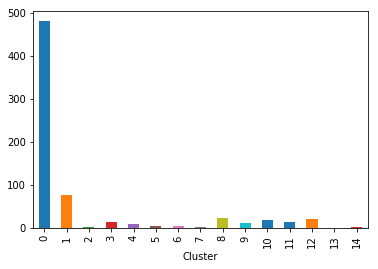

In [219]:
sf_restaurants.groupby('Cluster')['Venue'].count().plot(kind='bar')

Based on their density, we'll further analyze clusters numbers 0, 1, 8, and 12.


### Cluster Number 0

In [220]:
sf_cluster_0 = sf_restaurants[sf_restaurants.Cluster == 0]
sf_cluster_0.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
0,Marina,37.799793,-122.435205,Atelier Crenn,37.798403,-122.435835,French Restaurant,0
6,Marina,37.799793,-122.435205,Pacific Catch,37.800667,-122.436775,Seafood Restaurant,0
7,Marina,37.799793,-122.435205,Nabe II,37.799714,-122.436947,Hotpot Restaurant,0
8,Marina,37.799793,-122.435205,Café Castagna: Provençal Bistro,37.800744,-122.436604,French Restaurant,0
10,Marina,37.799793,-122.435205,Bistro Aix,37.800223,-122.437762,French Restaurant,0


#### Question 1:
What neighborhoods are in cluster zero?

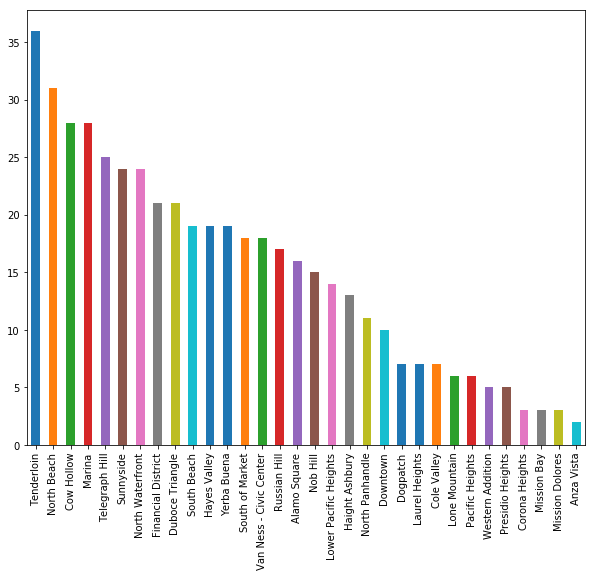

In [221]:
sf_cluster_0["Neighborhood"].value_counts().plot(kind='bar', figsize= (10,8))

#### Question 2:

What type of restaurants are the most frequent in cluster zero?

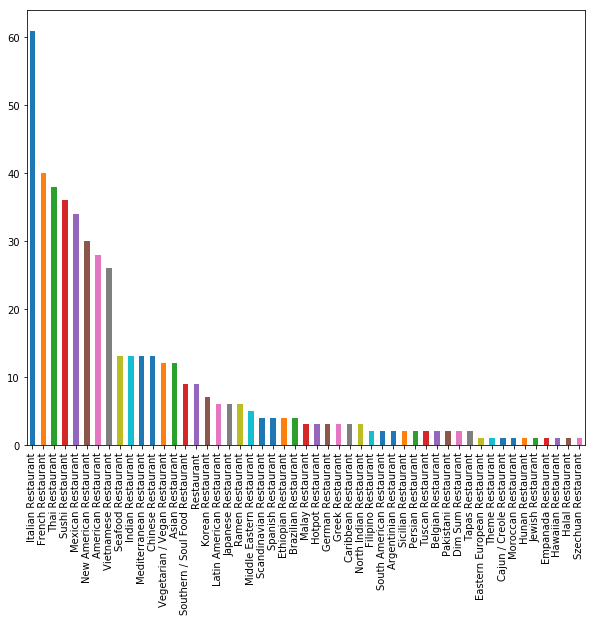

In [222]:
sf_cluster_0['Venue Category'].value_counts().plot(kind='bar', figsize=(10,8))

#### Question 3:
How many restaurants are there in cluster zero?

In [223]:
print('There are', sf_cluster_0.shape[0], ' restaurants in Cluster zero')

There are 481  restaurants in Cluster zero


### Cluster Number 1

In [224]:
sf_cluster_1 = sf_restaurants[sf_restaurants.Cluster == 1]
sf_cluster_1.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
703,Bernal Heights,37.741001,-122.414214,Nute's Noodle Night,37.738957,-122.413895,Asian Restaurant,1
704,Bernal Heights,37.741001,-122.414214,Red Hill Station,37.738936,-122.414479,Seafood Restaurant,1
709,Bernal Heights,37.741001,-122.414214,Piqueo's,37.738909,-122.414061,Peruvian Restaurant,1
711,Bernal Heights,37.741001,-122.414214,VinoRosso,37.739012,-122.415343,Italian Restaurant,1
716,Bernal Heights,37.741001,-122.414214,3rd Cousin,37.738983,-122.413740,New American Restaurant,1


#### Question 1:
What neighborhoods are in cluster one?

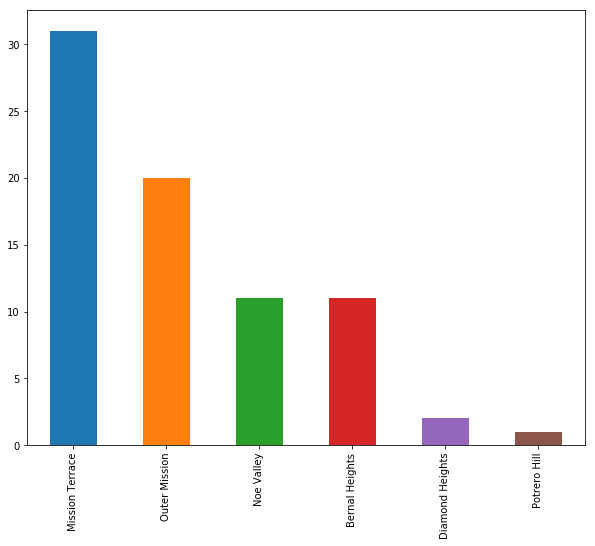

In [225]:
sf_cluster_1["Neighborhood"].value_counts().plot(kind='bar', figsize= (10,8))

#### Question 2:

What type of restaurants are the most frequent in cluster one?

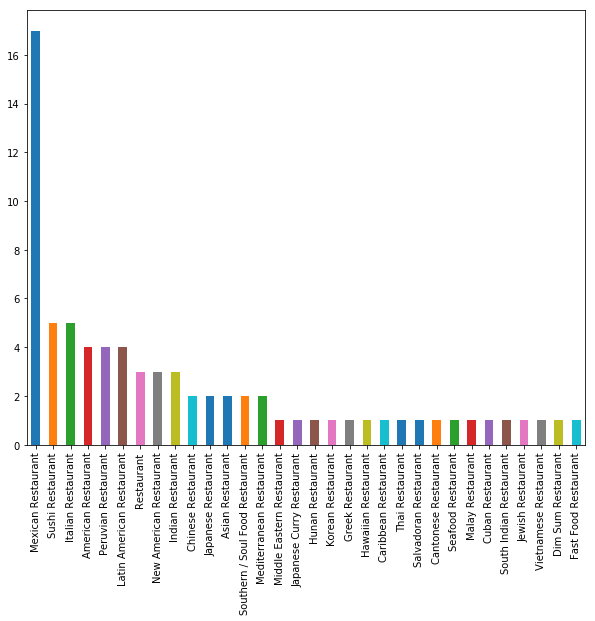

In [226]:
sf_cluster_1['Venue Category'].value_counts().plot(kind='bar', figsize=(10,8))

#### Question 3:
How many restaurants are there in cluster one?

In [227]:
print('There are', sf_cluster_1.shape[0], ' restaurants in Cluster one')

There are 76  restaurants in Cluster one


### Cluster Number 8

In [228]:
sf_cluster_8 = sf_restaurants[sf_restaurants.Cluster == 8]
sf_cluster_8.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
1664,Glen Park,37.733104,-122.433805,Manzoni,37.734678,-122.433898,Italian Restaurant,8
1666,Glen Park,37.733104,-122.433805,Le P'tit Laurent,37.734162,-122.433870,French Restaurant,8
1667,Glen Park,37.733104,-122.433805,La Corneta,37.733914,-122.434061,Mexican Restaurant,8
1680,Glen Park,37.733104,-122.433805,Win Garden,37.734549,-122.433899,Chinese Restaurant,8
1681,Glen Park,37.733104,-122.433805,One Waan Thai Restaurant,37.733184,-122.434386,Thai Restaurant,8


#### Question 1:
What neighborhoods are in cluster eight?

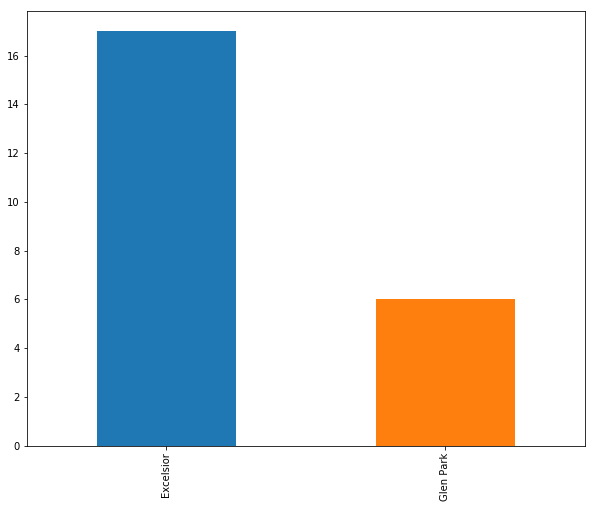

In [229]:
sf_cluster_8["Neighborhood"].value_counts().plot(kind='bar', figsize= (10,8))

#### Question 2:

What type of restaurants are the most frequent in cluster eight?

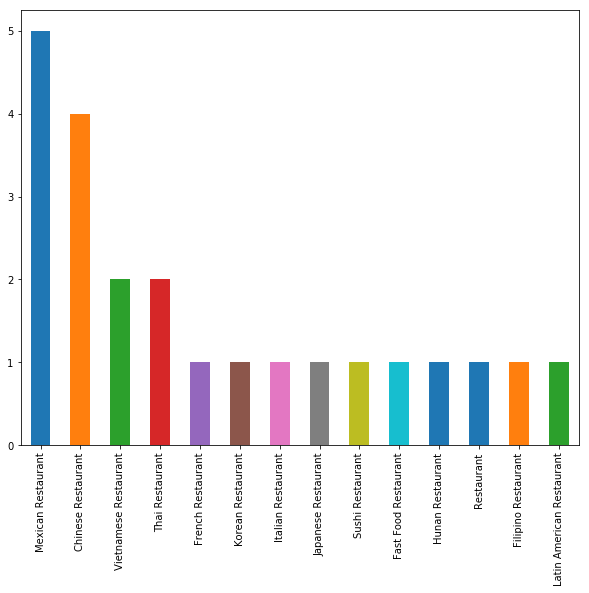

In [230]:
sf_cluster_8['Venue Category'].value_counts().plot(kind='bar', figsize=(10,8))

#### Question 3:
How many restaurants are there in cluster eight?

In [231]:
print('There are', sf_cluster_8.shape[0], ' restaurants in Cluster eight')

There are 23  restaurants in Cluster eight


### Cluster Number 12

In [232]:
sf_cluster_12 = sf_restaurants[sf_restaurants.Cluster == 12]
sf_cluster_12.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Cluster
2349,Westwood Park,37.727586,-122.459049,Champa Garden,37.724938,-122.460047,Asian Restaurant,12
2356,Westwood Park,37.727586,-122.459049,Sakesan Sushi | Robata,37.724290,-122.457454,Japanese Restaurant,12
2358,Westwood Park,37.727586,-122.459049,Joyful Kitchen,37.725377,-122.462722,Chinese Restaurant,12
2359,Westwood Park,37.727586,-122.459049,Kaisen Don,37.725513,-122.463015,Japanese Restaurant,12
2361,Westwood Park,37.727586,-122.459049,Golden Coast Restaurant,37.724559,-122.458988,Asian Restaurant,12


#### Question 1:
What neighborhoods are in cluster twelve?

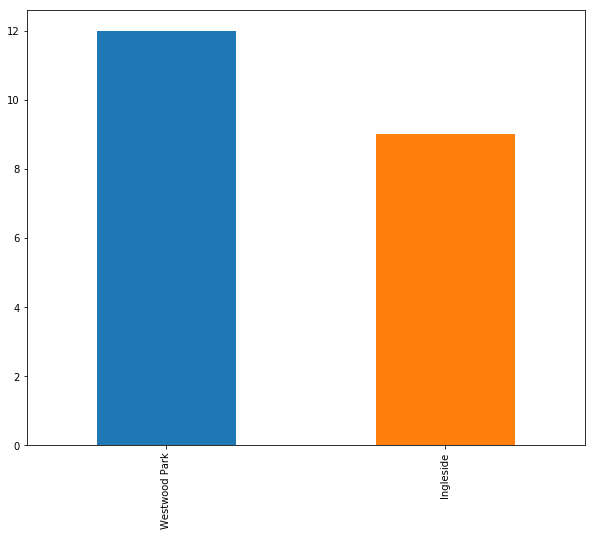

In [233]:
sf_cluster_12["Neighborhood"].value_counts().plot(kind='bar', figsize= (10,8))

#### Question 2:

What type of restaurants are the most frequent in cluster twelve?

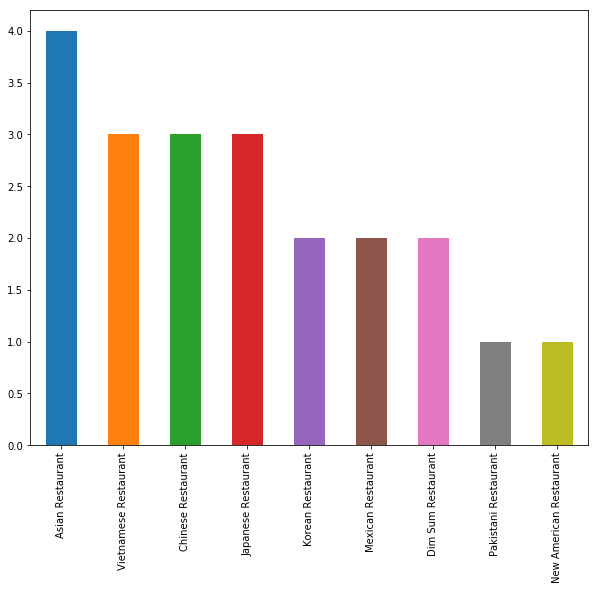

In [234]:
sf_cluster_12['Venue Category'].value_counts().plot(kind='bar', figsize=(10,8))

#### Question 3:
How many restaurants are there in cluster twelve?

In [235]:
print('There are', sf_cluster_12.shape[0], ' restaurants in Cluster twelve')

There are 21  restaurants in Cluster twelve


## Results and Discussion <a name="results"></a>

Popular types of restaurants in the more dense clusters:

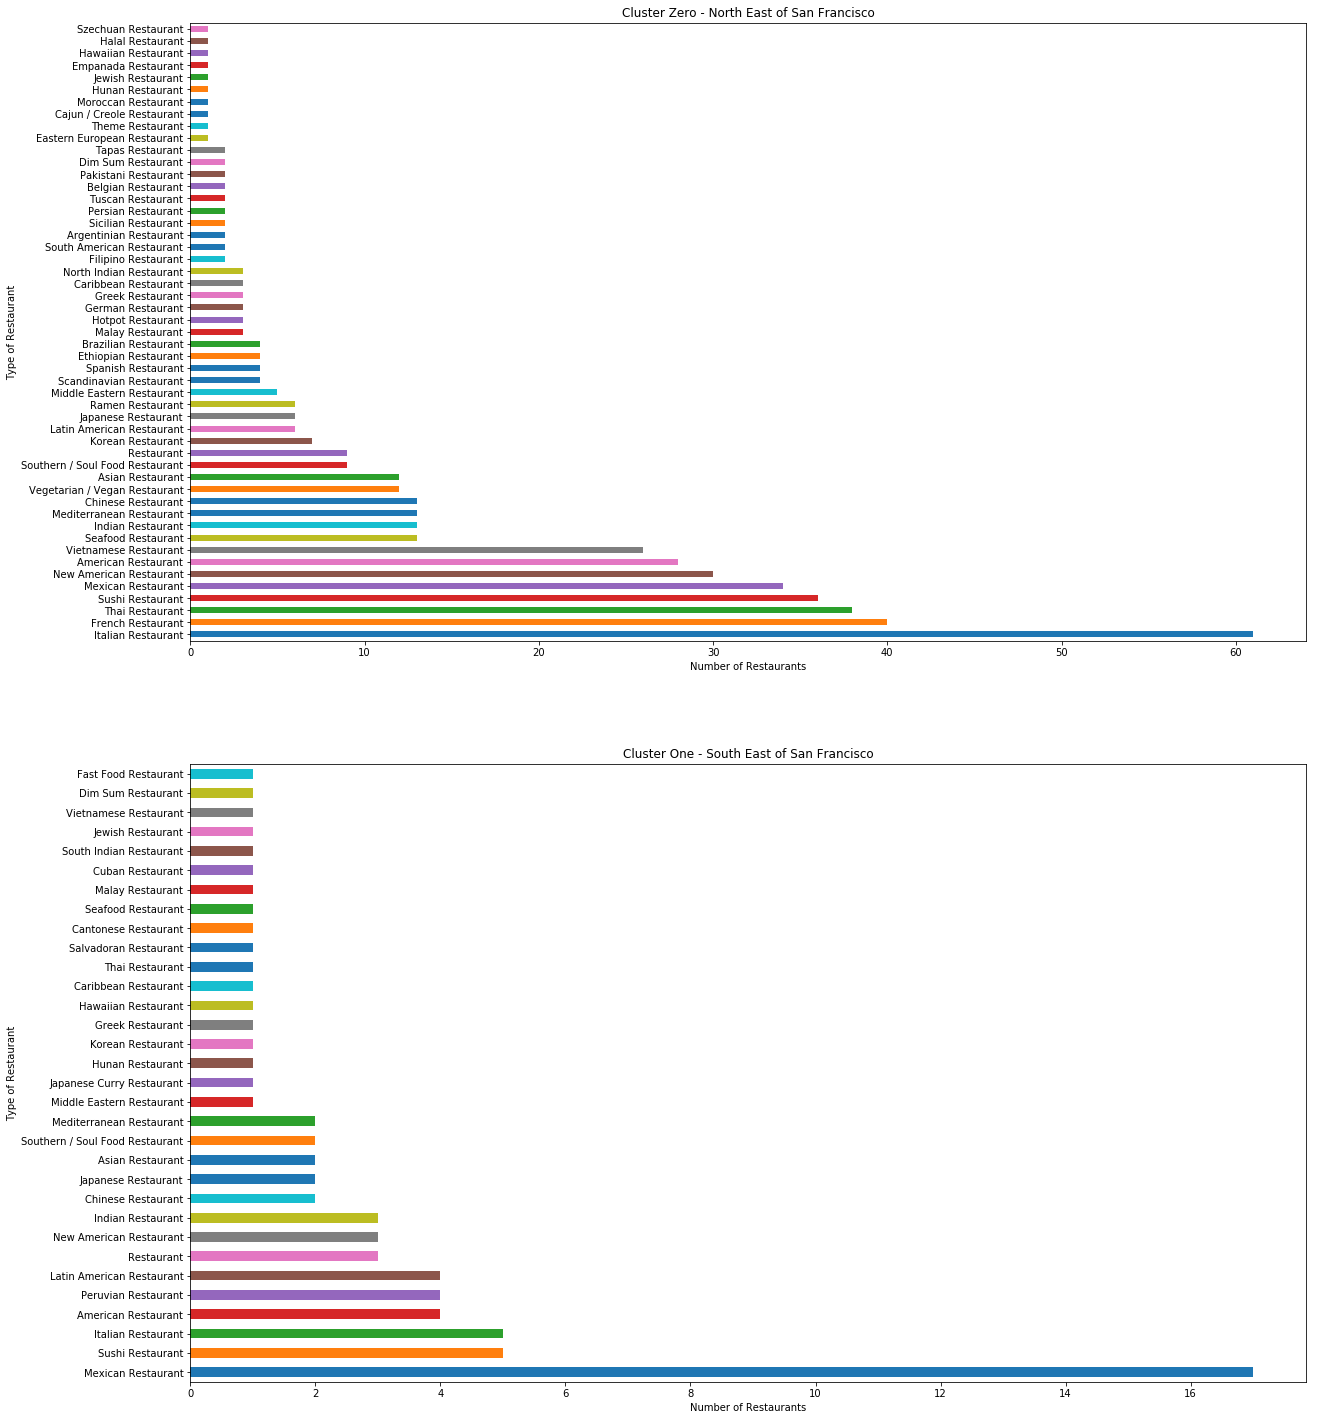

In [236]:
#Popular Restaurants in Clusters 0 and 1
fig = plt.figure() 

ax0 = fig.add_subplot(2, 1, 1) 
ax1 = fig.add_subplot(2, 1, 2) 

# Subplot 1: Cluster 0
sf_cluster_0['Venue Category'].value_counts().plot(kind='barh', figsize=(20, 25), ax=ax0) # add to subplot 1
ax0.set_title('Cluster Zero - North East of San Francisco')
ax0.set_xlabel('Number of Restaurants')
ax0.set_ylabel('Type of Restaurant')

# Subplot 2: Line plot
sf_cluster_1['Venue Category'].value_counts().plot(kind='barh', figsize=(20, 25), ax=ax1) # add to subplot 2
ax1.set_title ('Cluster One - South East of San Francisco')
ax1.set_ylabel('Type of Restaurant')
ax1.set_xlabel('Number of Restaurants')

plt.show()

Popular neighborhoods in the more dense clusters:

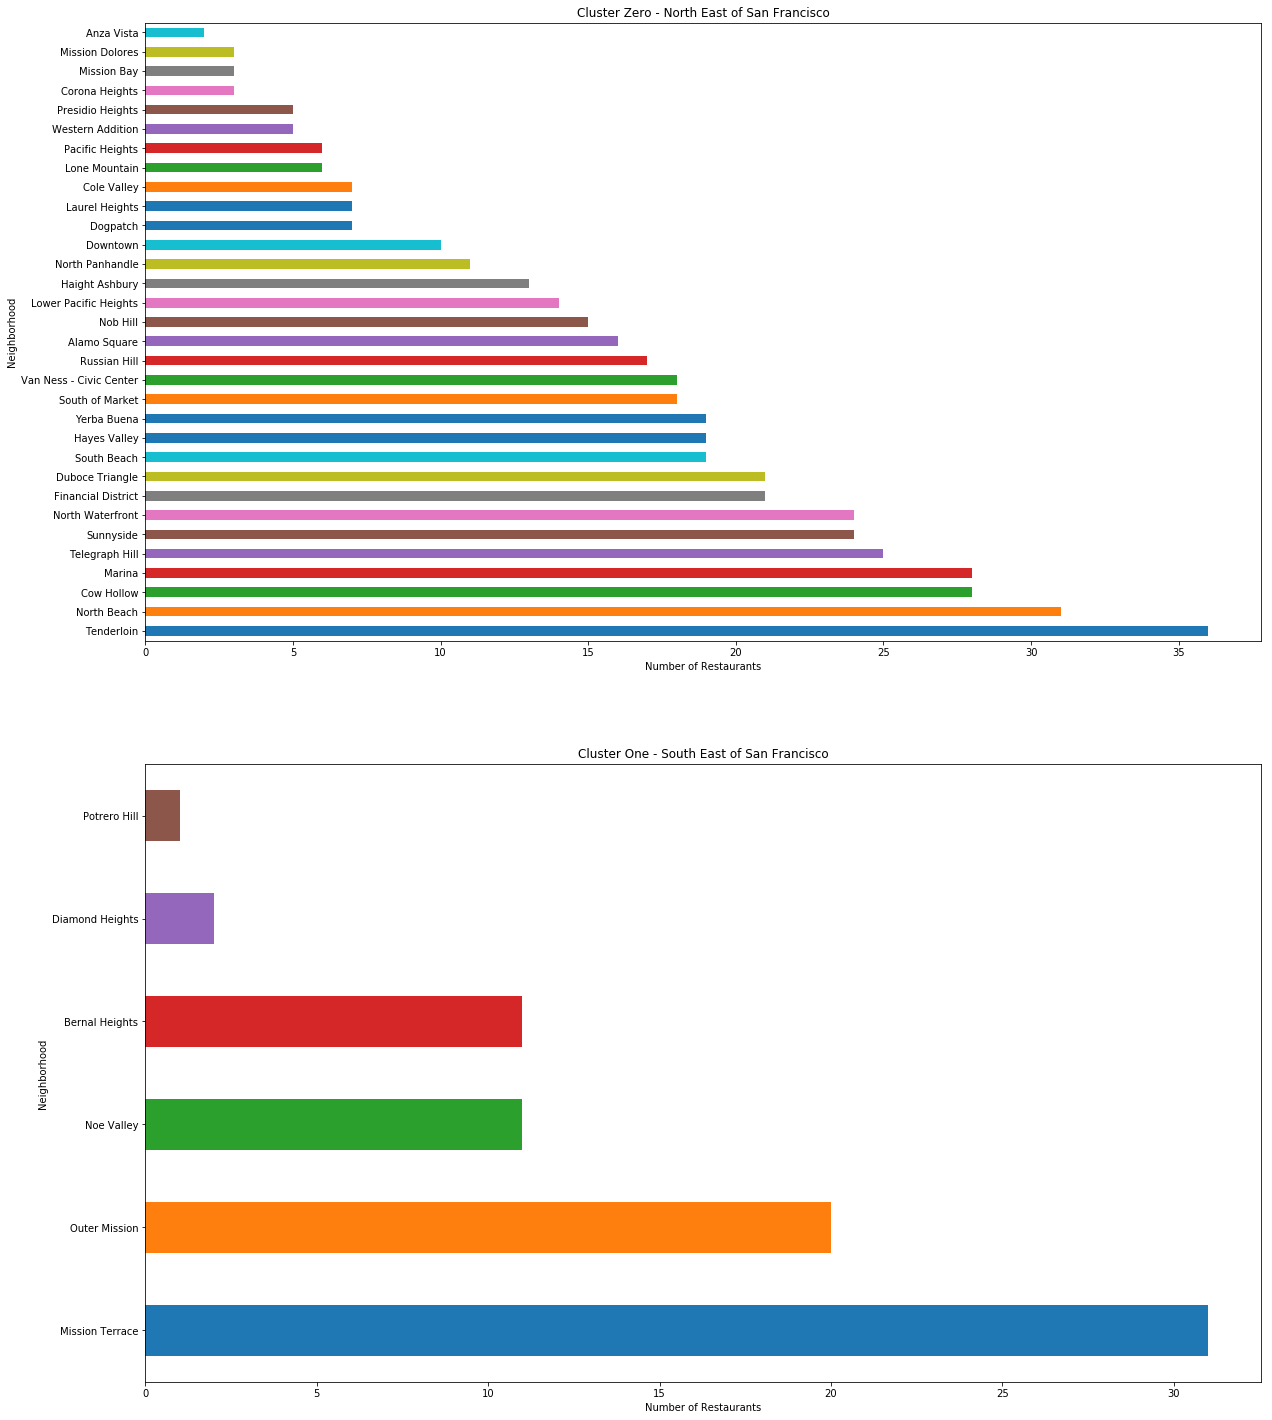

In [183]:
#Popular Neighborhoods in Clusters 0 and 1
fig = plt.figure() 

ax0 = fig.add_subplot(2, 1, 1) 
ax1 = fig.add_subplot(2, 1, 2) 

# Subplot 1: Cluster 0
sf_cluster_0['Neighborhood'].value_counts().plot(kind='barh', figsize=(20, 25), ax=ax0) # add to subplot 1
ax0.set_title('Cluster Zero - North East of San Francisco')
ax0.set_xlabel('Number of Restaurants')
ax0.set_ylabel('Neighborhood')

# Subplot 2: Line plot
sf_cluster_1['Neighborhood'].value_counts().plot(kind='barh', figsize=(20, 25), ax=ax1) # add to subplot 2
ax1.set_title ('Cluster One - South East of San Francisco')
ax1.set_ylabel('Neighborhood')
ax1.set_xlabel('Number of Restaurants')

plt.show()

### Discussion

From the graphs above, we can observe that there are types of restaurants that are more frequent than others in the city of San Francisco. For our analysis, we want to focus on those who are frequent but are not the most frequent ones to guaranteed the demand. 

In that case, the types of cuisine that will be more favorable to open a new restaurant are: Chinese, Mediterranean, Indian, and Seafood (around 13 of those in the cluster). 

As far as the neighborhoods, we've stated that we want to focus on those with high restaurant density, based on the plots, those neighborhoods are: Marina, Cow Hollow, North Beach, Tenderloin, and Mission Terrace. 

To limit our selection of neighborhoods, we'll explore the average rent prices for each area:

In [238]:
#Now, let's check the average rent price of those places to have a better idea of which neighborhood will be best to open a restaurant
pointed_neighborhoods = ['Marina', 'Cow Hollow', 'North Beach', 'Tenderloin', 'Mission Terrace']

best_neighborhoods = df.loc[df['Neighborhood'].isin(pointed_neighborhoods)]
best_neighborhoods

,Neighborhood,Avg-rent,Latitude,Longitude
0,Marina,"$2,959",37.799793,-122.435205
2,Tenderloin,"$2,979",37.784249,-122.413993
16,North Beach,"$3,321",37.801175,-122.409002
18,Cow Hollow,"$3,385",37.797262,-122.436248
49,Mission Terrace,"$3,942",37.752498,-122.412826


In [240]:
#Creating map again
map_sf = folium.Map(location=[latitude, longitude], zoom_start = 11.49)

for latitude, longitude, neighborhood, avg_rent in zip(best_neighborhoods['Latitude'], best_neighborhoods['Longitude'], best_neighborhoods['Neighborhood'], best_neighborhoods['Avg-rent']):
    label = '{}, {}'.format(neighborhood, avg_rent)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius = 5, 
        popup = label,
        color = 'blue',
        fill = True,
        fill_color = '#3186cc',
        fill_opacity = 0.7,
        parse_html= False).add_to(map_sf)

map_sf

## Conclusion <a name="conclusion"></a>

The purpose of this project was to identify neighborhoods of San Francisco with high restaurant density in order to aid stakeholders in narrowing down the search for optimal location for a new restaurant. By accessing the restaurant data from Foursquare API, and with the aid of a DBSCAN machine learning algorithm to visualize its density distribution, we have identified two optimal neighborhoods: Marina and Tenderloin. 

As far as the type of cuisine, the research has shown that there is market for a vast type of restaurants, but the demand for the Chinese, Mediterranean, Indian, and Seafood cuisine in the city of San Francisco is promising. 

